Extraction of image features


In [1]:
!pip install opencv-python numpy scikit-learn imutils

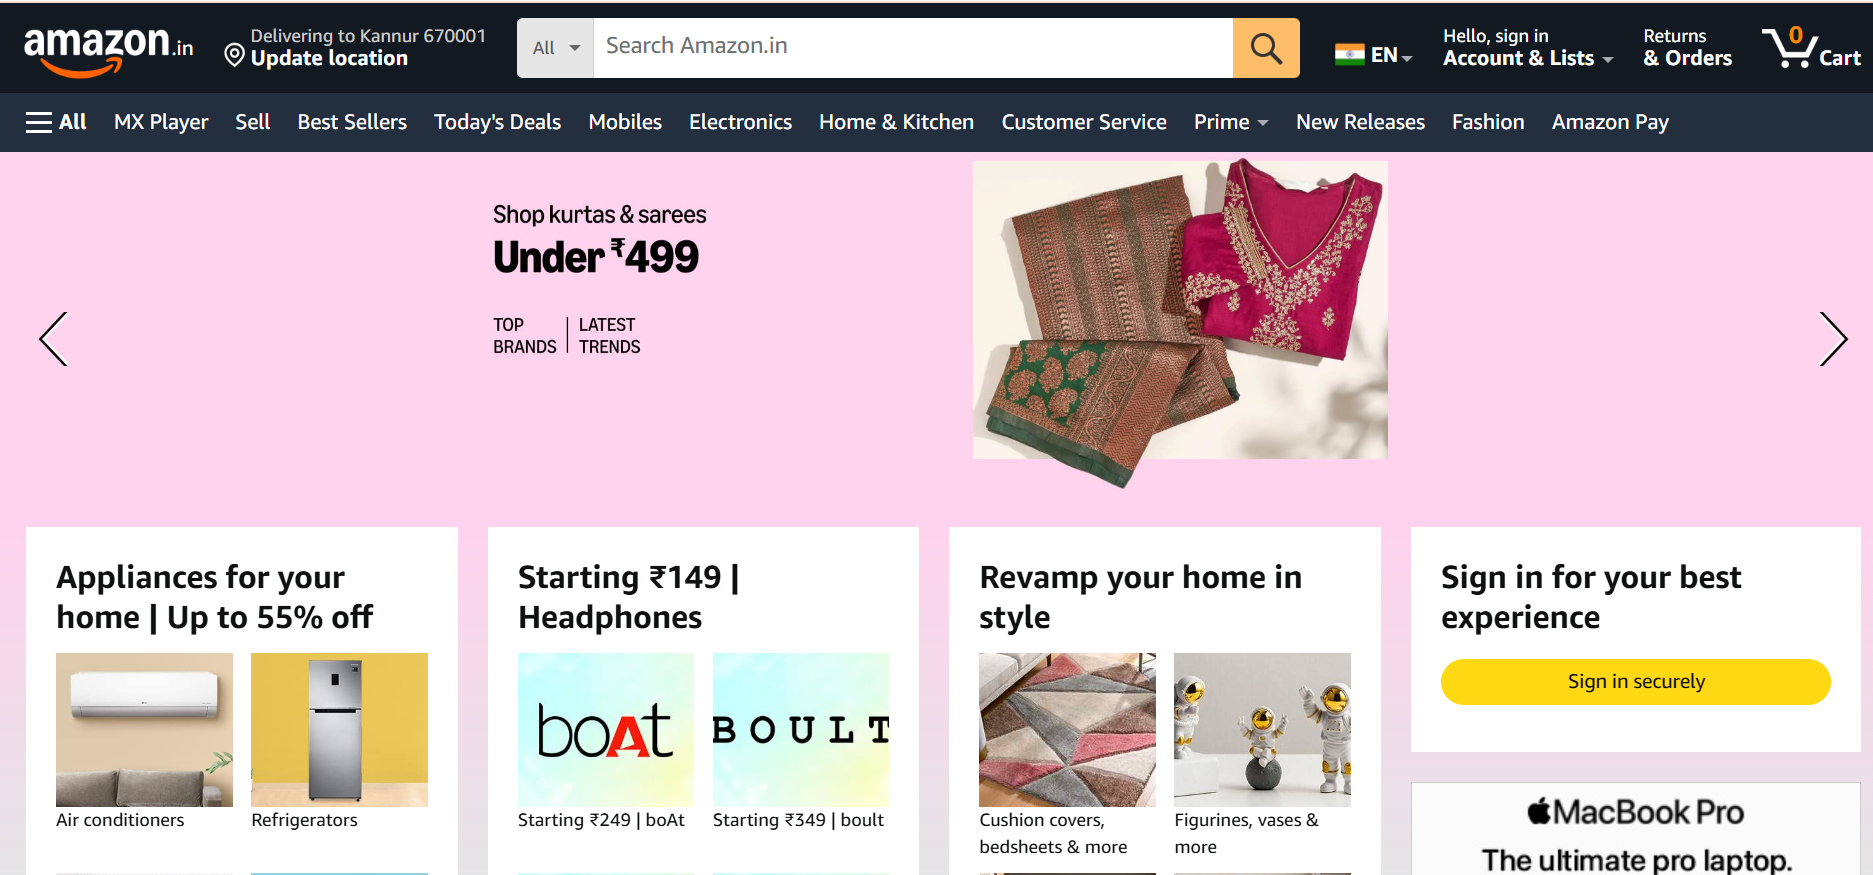

In [2]:
from IPython.display import Image, display

# Assuming the image is uploaded and accessible at 'image_path'
image_path = "/content/amzn.PNG"  #
# Display the image
display(Image(filename=image_path))

In [3]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import imutils

def analyze_website_screenshot(image_path):
    """
    Analyzes a website screenshot to extract visual elements and colors.

    Parameters:
    image_path (str): Path to the website screenshot image

    Returns:
    dict: Dictionary containing analysis results
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not read the image")

    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def extract_color_palette(image, n_colors=5):
        # Reshape image to be a list of pixels
        pixels = image.reshape(-1, 3)

        # Use KMeans to find dominant colors
        kmeans = KMeans(n_clusters=n_colors, random_state=42)
        kmeans.fit(pixels)

        # Get the colors and convert to hex
        colors = kmeans.cluster_centers_
        hex_colors = ['#%02x%02x%02x' % tuple(map(int, color)) for color in colors]

        return hex_colors

    def detect_background_color(image):
        # Assume the most common color is the background
        pixels = image.reshape(-1, 3)
        counts = Counter(map(tuple, pixels))
        background_color = max(counts.items(), key=lambda x: x[1])[0]
        return '#{:02x}{:02x}{:02x}'.format(*background_color)

    def detect_buttons(image):
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Apply threshold
        _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

        # Find contours
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)

        buttons = []
        for contour in contours:
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)

            # Filter based on aspect ratio and size
            aspect_ratio = w / float(h)
            if 2 <= aspect_ratio <= 5 and w >= 50 and h >= 20:
                buttons.append({
                    'position': (x, y),
                    'size': (w, h)
                })

        return buttons

    def detect_shapes(image):
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Apply threshold
        _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

        # Find contours
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)

        shapes = {
            'rectangles': 0,
            'circles': 0,
            'triangles': 0,
            'other': 0
        }

        for contour in contours:
            # Approximate the contour
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.04 * peri, True)

            # Identify shape based on vertices
            if len(approx) == 3:
                shapes['triangles'] += 1
            elif len(approx) == 4:
                shapes['rectangles'] += 1
            elif len(approx) > 8:
                # Assume it's a circle if it has many vertices
                shapes['circles'] += 1
            else:
                shapes['other'] += 1

        return shapes

    def analyze_layout(image):
        # Simple layout analysis based on content distribution
        height, width = image.shape[:2]

        # Divide image into sections
        sections = {
            'header': image[0:int(height*0.2), :],
            'content': image[int(height*0.2):int(height*0.8), :],
            'footer': image[int(height*0.8):, :]
        }

        layout_analysis = {}
        for section_name, section in sections.items():
            # Check if section has content (non-white pixels)
            gray = cv2.cvtColor(section, cv2.COLOR_RGB2GRAY)
            non_white = np.count_nonzero(gray < 250)
            layout_analysis[section_name] = {
                'has_content': non_white > (section.shape[0] * section.shape[1] * 0.1)
            }

        return layout_analysis

    # Perform all analyses
    analysis_results = {
        'color_palette': extract_color_palette(image_rgb),
        'background_color': detect_background_color(image_rgb),
        'buttons': detect_buttons(image_rgb),
        'shapes': detect_shapes(image_rgb),
        'layout': analyze_layout(image_rgb)
    }

    return analysis_results

# Example usage
if __name__ == "__main__":
    try:
        results = analyze_website_screenshot("/content/amzn.PNG")
        print("Analysis Results:")
        print(f"Color Palette: {results['color_palette']}")
        print(f"Background Color: {results['background_color']}")
        print(f"Number of Buttons: {len(results['buttons'])}")
        print(f"Shapes Detected: {results['shapes']}")
        print(f"Layout Analysis: {results['layout']}")
    except Exception as e:
        print(f"Error: {str(e)}")

Analysis Results:
Color Palette: ['#d5b979', '#1b222c', '#fad4eb', '#885251', '#fbfdfb']
Background Color: #ffd3ee
Number of Buttons: 5
Shapes Detected: {'rectangles': 32, 'circles': 0, 'triangles': 4, 'other': 199}
Layout Analysis: {'header': {'has_content': True}, 'content': {'has_content': True}, 'footer': {'has_content': True}}


In [4]:
!pip install pytesseract pillow webcolors matplotlib

In [5]:
!apt-get update
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,105 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,438 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease

In [6]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pytesseract
from PIL import Image
import colorsys
from webcolors import rgb_to_name
import matplotlib.pyplot as plt

class ColorAnalysis:
    @staticmethod
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

    @staticmethod
    def get_color_name(rgb):
        try:
            return rgb_to_name(rgb)
        except ValueError:
            return None

    @staticmethod
    def extract_color_palette(image, n_colors=5):
        # Convert image to RGB if it's not
        if len(image.shape) == 3 and image.shape[2] == 3:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_rgb = image

        # Reshape image to be a list of pixels
        pixels = image_rgb.reshape(-1, 3)

        # Use KMeans to find dominant colors
        kmeans = KMeans(n_clusters=n_colors, random_state=42)
        kmeans.fit(pixels)

        # Get color counts
        labels = kmeans.labels_
        label_counts = Counter(labels)

        # Calculate percentages and sort colors by frequency
        total_pixels = sum(label_counts.values())

        colors = []
        for i in range(n_colors):
            center = kmeans.cluster_centers_[i]
            hex_color = ColorAnalysis.rgb_to_hex(center)
            percentage = (label_counts[i] / total_pixels) * 100

            # Convert RGB to HSV for additional information
            hsv = colorsys.rgb_to_hsv(center[0]/255, center[1]/255, center[2]/255)

            color_info = {
                'hex': hex_color,
                'rgb': tuple(map(int, center)),
                'percentage': round(percentage, 2),
                'hsv': {
                    'hue': round(hsv[0] * 360),
                    'saturation': round(hsv[1] * 100),
                    'value': round(hsv[2] * 100)
                },
                'name': ColorAnalysis.get_color_name(tuple(map(int, center)))
            }
            colors.append(color_info)

        return sorted(colors, key=lambda x: x['percentage'], reverse=True)

class TypographyAnalysis:
    def __init__(self):
        # Configure Tesseract parameters for better text detection
        self.custom_config = r'--oem 3 --psm 11'

    def detect_text_properties(self, image):
        """
        Detects text properties including font sizes and styles
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply thresholding to get better text detection
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        # Get text data using Tesseract
        text_data = pytesseract.image_to_data(binary, config=self.custom_config, output_type=pytesseract.Output.DICT)

        # Analyze text properties
        font_sizes = []
        text_blocks = []

        for i in range(len(text_data['text'])):
            if int(text_data['conf'][i]) > 60:  # Filter low-confidence detections
                text = text_data['text'][i].strip()
                if text:
                    block = {
                        'text': text,
                        'confidence': text_data['conf'][i],
                        'bbox': (
                            text_data['left'][i],
                            text_data['top'][i],
                            text_data['width'][i],
                            text_data['height'][i]
                        ),
                        'font_size': text_data['height'][i],  # Approximate font size based on height
                        'line_num': text_data['line_num'][i]
                    }
                    text_blocks.append(block)
                    font_sizes.append(text_data['height'][i])

        # Analyze font size distribution
        if font_sizes:
            font_analysis = {
                'min_size': min(font_sizes),
                'max_size': max(font_sizes),
                'average_size': sum(font_sizes) / len(font_sizes),
                'size_distribution': Counter(font_sizes)
            }
        else:
            font_analysis = {
                'min_size': None,
                'max_size': None,
                'average_size': None,
                'size_distribution': {}
            }

        return {
            'text_blocks': text_blocks,
            'font_analysis': font_analysis
        }

def analyze_website_screenshot(image_path):
    """
    Analyzes a website screenshot to extract visual elements, colors, and typography.

    Parameters:
    image_path (str): Path to the website screenshot image

    Returns:
    dict: Dictionary containing analysis results
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not read the image")

    # Initialize analyzers
    color_analyzer = ColorAnalysis()
    typography_analyzer = TypographyAnalysis()

    def detect_buttons(image):
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply threshold
        _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

        # Find contours
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)

        buttons = []
        for contour in contours:
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)

            # Filter based on aspect ratio and size
            aspect_ratio = w / float(h)
            if 2 <= aspect_ratio <= 5 and w >= 50 and h >= 20:
                buttons.append({
                    'position': (x, y),
                    'size': (w, h)
                })

        return buttons

    def detect_shapes(image):
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply threshold
        _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

        # Find contours
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)

        shapes = {
            'rectangles': 0,
            'circles': 0,
            'triangles': 0,
            'other': 0
        }

        for contour in contours:
            # Approximate the contour
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.04 * peri, True)

            if len(approx) == 3:
                shapes['triangles'] += 1
            elif len(approx) == 4:
                shapes['rectangles'] += 1
            elif len(approx) > 8:
                shapes['circles'] += 1
            else:
                shapes['other'] += 1

        return shapes

    def analyze_layout(image):
        height, width = image.shape[:2]

        sections = {
            'header': image[0:int(height*0.2), :],
            'content': image[int(height*0.2):int(height*0.8), :],
            'footer': image[int(height*0.8):, :]
        }

        layout_analysis = {}
        for section_name, section in sections.items():
            gray = cv2.cvtColor(section, cv2.COLOR_BGR2GRAY)
            non_white = np.count_nonzero(gray < 250)
            layout_analysis[section_name] = {
                'has_content': non_white > (section.shape[0] * section.shape[1] * 0.1)
            }

        return layout_analysis

    def visualize_color_palette(colors):
        # Create a figure with a white background
        plt.figure(figsize=(10, 2))

        # Create color swatches
        for idx, color_info in enumerate(colors):
            plt.bar(idx, 1, color=color_info['hex'], width=1)
            plt.text(idx, -0.1, f"{color_info['percentage']:.1f}%",
                    ha='center', va='top', rotation=0)

        plt.xlim(-0.5, len(colors) - 0.5)
        plt.ylim(-0.2, 1.2)
        plt.axis('off')
        plt.title('Color Palette')

        # Save the visualization
        plt.savefig('color_palette.png', bbox_inches='tight', dpi=300)
        plt.close()

    # Perform all analyses
    color_palette = color_analyzer.extract_color_palette(image)
    typography_results = typography_analyzer.detect_text_properties(image)

    # Create visualization
    visualize_color_palette(color_palette)

    analysis_results = {
        'color_analysis': {
            'palette': color_palette,
            'visualization': 'color_palette.png'
        },
        'typography': typography_results,
        'buttons': detect_buttons(image),
        'shapes': detect_shapes(image),
        'layout': analyze_layout(image)
    }

    return analysis_results

# Example usage
if __name__ == "__main__":
    try:
        results = analyze_website_screenshot("/content/amzn.PNG")

        # Print color analysis
        print("\nColor Analysis:")
        for idx, color in enumerate(results['color_analysis']['palette'], 1):
            print(f"\nColor {idx}:")
            print(f"  Hex: {color['hex']}")
            print(f"  RGB: {color['rgb']}")
            print(f"  Percentage: {color['percentage']}%")
            print(f"  HSV: {color['hsv']}")
            if color['name']:
                print(f"  Name: {color['name']}")

        # Print typography analysis
        print("\nTypography Analysis:")
        print(f"Number of text blocks: {len(results['typography']['text_blocks'])}")
        print("\nFont size analysis:")
        font_analysis = results['typography']['font_analysis']
        print(f"  Min size: {font_analysis['min_size']}")
        print(f"  Max size: {font_analysis['max_size']}")
        print(f"  Average size: {round(font_analysis['average_size'], 2) if font_analysis['average_size'] else None}")

        # Print other analyses
        print(f"\nNumber of Buttons: {len(results['buttons'])}")
        print(f"Shapes Detected: {results['shapes']}")
        print(f"Layout Analysis: {results['layout']}")

    except Exception as e:
        print(f"Error: {str(e)}")


results = analyze_website_screenshot("/content/amzn.PNG")


Color Analysis:

Color 1:
  Hex: #fad4eb
  RGB: (250, 212, 235)
  Percentage: 41.99%
  HSV: {'hue': 324, 'saturation': 15, 'value': 98}

Color 2:
  Hex: #fbfdfb
  RGB: (251, 253, 251)
  Percentage: 30.82%
  HSV: {'hue': 135, 'saturation': 1, 'value': 100}

Color 3:
  Hex: #1b222c
  RGB: (27, 34, 44)
  Percentage: 15.18%
  HSV: {'hue': 214, 'saturation': 38, 'value': 17}

Color 4:
  Hex: #d5b979
  RGB: (213, 185, 121)
  Percentage: 6.05%
  HSV: {'hue': 42, 'saturation': 43, 'value': 84}

Color 5:
  Hex: #885251
  RGB: (136, 82, 81)
  Percentage: 5.95%
  HSV: {'hue': 1, 'saturation': 40, 'value': 53}

Typography Analysis:
Number of text blocks: 79

Font size analysis:
  Min size: 5
  Max size: 54
  Average size: 20.47

Number of Buttons: 5
Shapes Detected: {'rectangles': 32, 'circles': 0, 'triangles': 4, 'other': 199}
Layout Analysis: {'header': {'has_content': True}, 'content': {'has_content': True}, 'footer': {'has_content': True}}


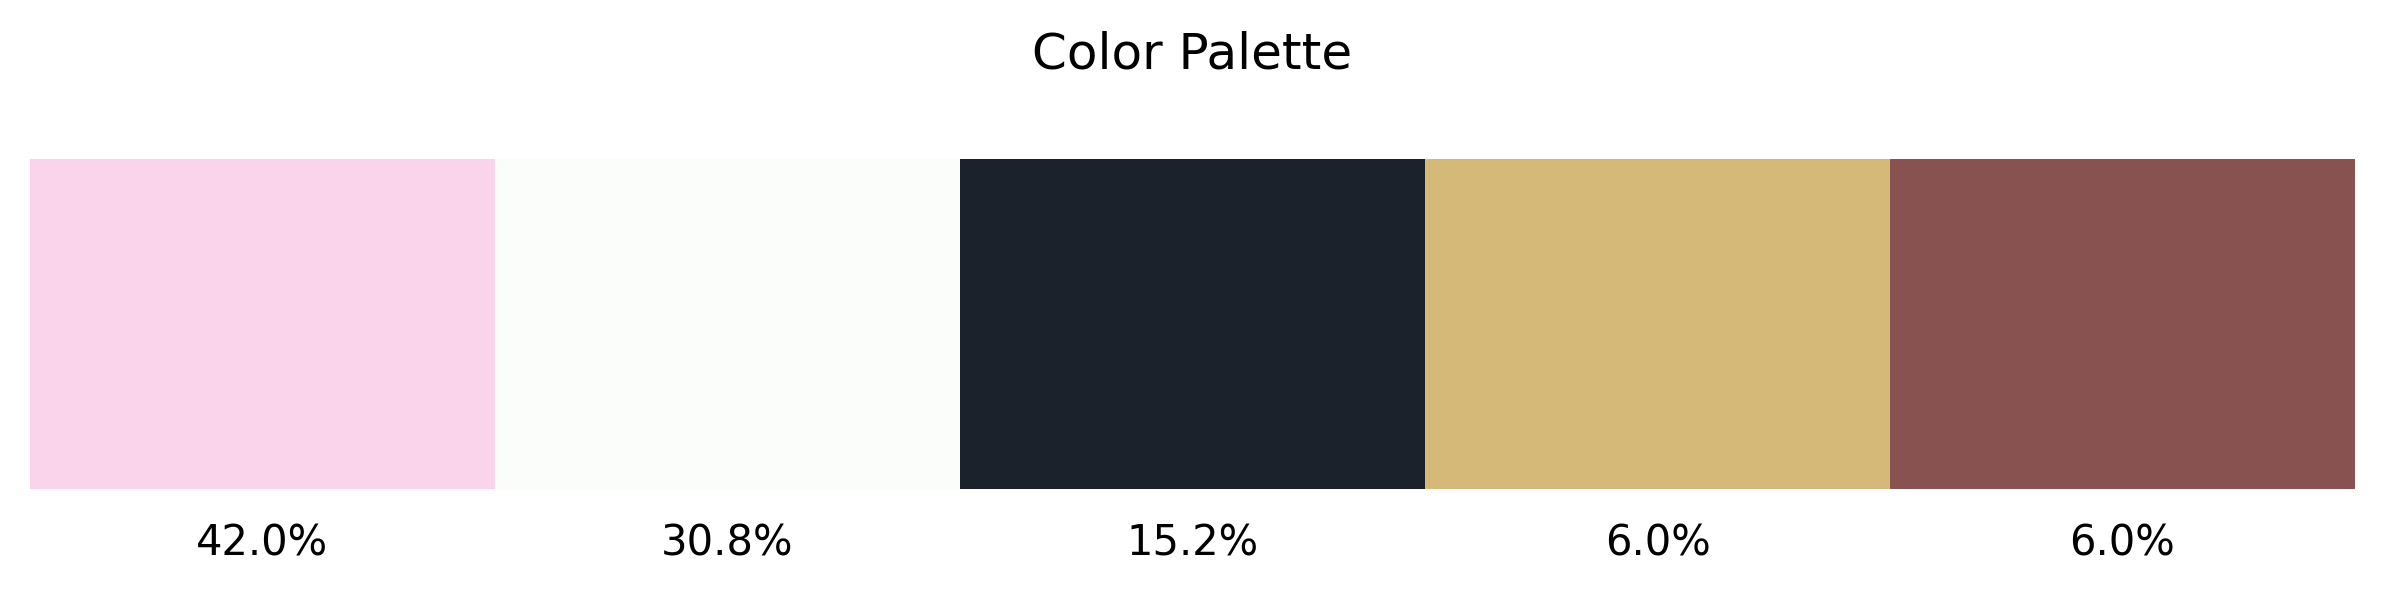

In [7]:
from IPython.display import display
from PIL import Image  # Import Image for display in IPython

color_pt = "/content/color_palette.png"
# Open the image using Image.open()
image1 = Image.open(color_pt)
# Display the image using display()
display(image1)